#### 2D heat equation
$u_{t} = D(u_{xx}+u_{yy})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import random
from sklearn.metrics import mean_squared_error
import matplotlib.image as mpimg


In [3]:
from functions import data_normalize, flattern, DE_Learner, split_final
import tensorflow as tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Training dara generation

In [7]:
output ='./graphs/'

Time series data size:  10000 1502
dt:  9.999999999999999e-05


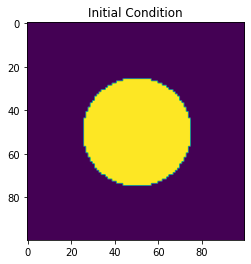

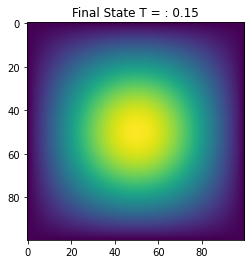

In [8]:
# plate size,

w = h = 2.
# intervals in x-, y- directions, mm
dx = dy = .02
# Thermal diffusivity of steel, mm2.s-1
D = 1.

Tcool, Thot = .1, .9

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

# Initial conditions - ring of inner radius r, width dr centred at (cx,cy) (mm)
r, cx, cy = .5, 1, 1
r2 = r**2
heat_dat = [[] for _ in range(int(nx*ny))]
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot
k = 0
for i in range(nx):
    for j in range(ny):
        heat_dat[k].append(u0[i,j])
        k+= 1
plt.figure()
plt.imshow(u0)
plt.title('Initial Condition')
def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u
time_step = 1500
for steps in range(time_step+1):
    u0, u = do_timestep(u0, u)
    k = 0
    for i in range(nx):
        for j in range(ny):
            heat_dat[k].append(u0[i,j])
            k+= 1
plt.figure()
plt.imshow(u0)
plt.title('Final State T = : '+ str(dt*time_step))
print('Time series data size: ', len(heat_dat), len(heat_dat[0]))
print('dt: ',dt)

In [9]:
a = dx2 * dy2
b =  (2 * D * (dx2 + dy2))
print(a/b)

9.999999999999999e-05


In [10]:
t1, t2 = 30,10
heat_final_x = [h[-t1-t2:-t2] for h in heat_dat]
heat_final_y = [h[-t2:] for h in heat_dat]
heat_final_x = np.array(heat_final_x).reshape(1, len(heat_final_x),len(heat_final_x[0]))
heat_final_y = np.array(heat_final_y).reshape(1, len(heat_final_y),len(heat_final_y[0]))
heat_dat = np.array([h[:-t1-t2] for h in heat_dat])
heat_dat.shape

(10000, 1462)

#### Deep Nueral Network

training time period:  0.0029999999999999996
test time period:  0.001
###########################START##########################
Whole data size(batch, row, column) (1422, 10000, 30) (1422, 10000, 10)
Train data size(batch, row, column) (1137, 10000, 30) (1137, 10000, 10)
test data size(batch, row, column) (285, 10000, 30) (285, 10000, 10)
Epoch 1/5
455/455 [==============================] - 361s 767ms/step - loss: 0.0011 - val_loss: 2.4617e-05
Epoch 2/5
455/455 [==============================] - 342s 752ms/step - loss: 2.1889e-05 - val_loss: 5.1143e-05
Epoch 3/5
455/455 [==============================] - 342s 751ms/step - loss: 1.8803e-05 - val_loss: 1.3900e-05
Epoch 4/5
455/455 [==============================] - 343s 753ms/step - loss: 1.3737e-05 - val_loss: 7.1123e-06
Epoch 5/5
455/455 [==============================] - 343s 754ms/step - loss: 1.1019e-05 - val_loss: 2.1423e-05
Model: "sequential"
_________________________________________________________________
Layer (type)         

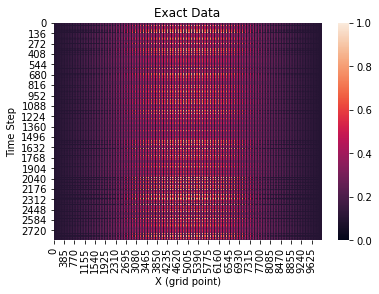

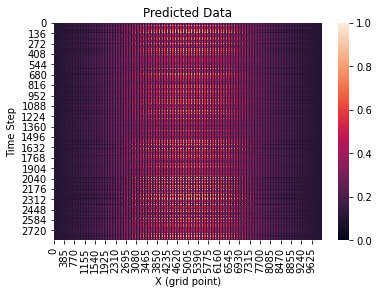

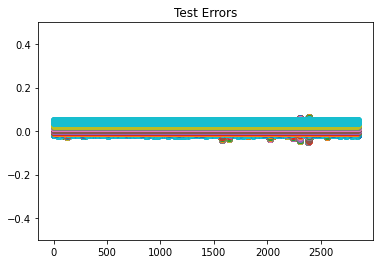

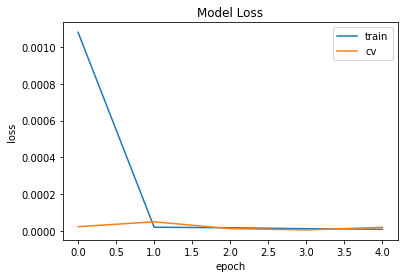

----------------MSE:  2.274929262911876e-05
###########################END##########################


In [11]:

print('training time period: ', dt*t1)
print('test time period: ', dt*t2)
heat_py, heat_ty, heat_mse, heatmodel = DE_Learner(heat_dat,t1,t2, 1, 0.2,  'heat')




In [14]:
print(heat_final_x.shape)
heat_final_pred = heatmodel.predict(heat_final_x,verbose=1)

(1, 10000, 30)
1/1 [==============================] - 0s 363ms/step


0
3
6
9


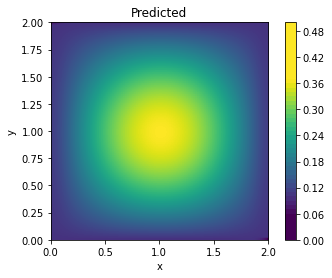

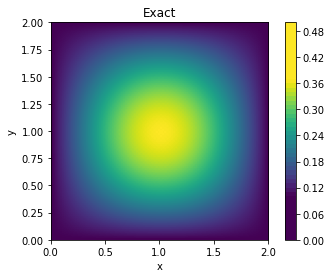

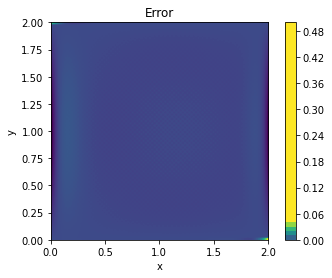

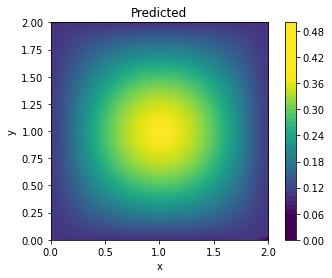

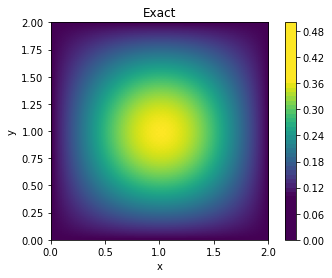

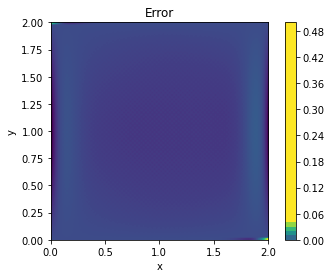

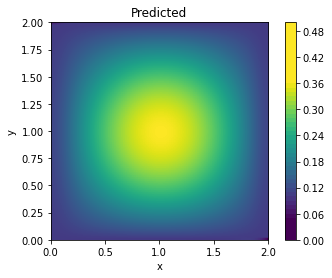

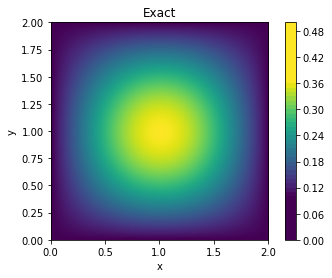

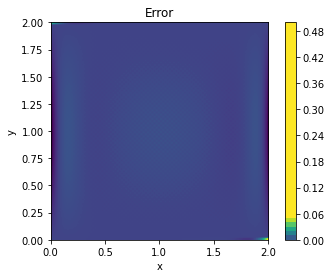

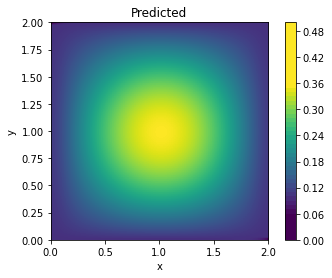

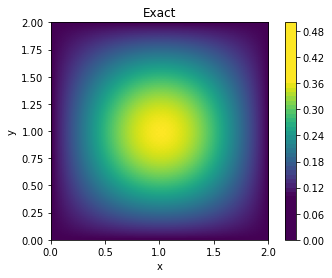

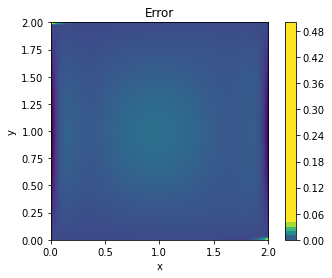

In [15]:
heat_final_py = np.array(flattern(heat_final_pred)).T
heat_final_ty = np.array(flattern(heat_final_y)).T
idx = -1 #random.randint(0, len(heat_ty)-1)
heat_idx = [0,3,6,9]
for idx in heat_idx:
    k = 0
    print(idx)
    v0 = np.ones((nx,ny))
    u0 = np.ones((nx,ny))
    e = np.ones((nx,ny))
    for i in range(nx):
        for j in range(ny):
            v0[i,j] = heat_final_py[idx][k]
            u0[i,j] = heat_final_ty[idx][k]
            e[i,j] =  u0[i,j] - v0[i,j]
            k+=1
    heatfig1 = plt.figure()
    plt.imshow(v0,extent=[0, w, 0, h])
    plt.title('Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    s = 0.01
    plt.colorbar(boundaries=np.linspace(0, .5, int(.5/s) +1))
    heatfig1.savefig(output+'Heat_Predict_Data_' + str(idx)+'.pdf',bbox_inches='tight')
    heatfig2 = plt.figure()
    plt.imshow(u0,extent=[0, w, 0, h])
    plt.title('Exact')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(boundaries=np.linspace(0, .5, int(.5/s) +1))
    heatfig2.savefig(output+'Heat_Exact_Data_' + str(idx)+'.pdf',bbox_inches='tight')
    heatfig3 = plt.figure()
    plt.imshow(e,extent=[0, w, 0, h])
    plt.title('Error')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(boundaries=np.linspace(0, .5, int(.5/s) +1))
    heatfig3.savefig(output+'Heat_Error_Data_' + str(idx)+'.pdf',bbox_inches='tight')
# wave3d = plt.figure()
# ax = wave3d.gca(projection='3d')
# X, Y = np.meshgrid(np.linspace(0,w, nx), np.linspace(0,w, ny))
# surf = ax.plot_surface(X, Y, u0,rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
# ax.set_title('Exact Data at time: '+str(dt*nt))
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('U')
# wave3d = plt.figure()
# ax = wave3d.gca(projection='3d')
# X, Y = np.meshgrid(np.linspace(0,w, nx), np.linspace(0,w, ny))
# surf = ax.plot_surface(X, Y, v0,rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
# ax.set_title('u predicted Data at time: '+str(dt*nt))
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('U')
# wave3d = plt.figure()
# ax = wave3d.gca(projection='3d')
# X, Y = np.meshgrid(np.linspace(0,w, nx), np.linspace(0,w, ny))
# surf = ax.plot_surface(X, Y, e,rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
# ax.set_title('error: '+str(dt*nt))
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('Error')